# Detecting Pneumonia With Transfer Learning

Author: **Marcin Sikorski**<br>
Date: November, 2023

Update of binary classification based on patient's chest X-ray images. The label predictions will be performed by implementing transfer learning, a machine-learning and computer vision technique which enables us to reuse pre-trained models and datasets for new tasks and domains.

**Data source:** [Chest X-ray Images](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images)

**Notebook Content:**
1. Preparing Environment & Images For Deep Learning
2. ResNet50V2
3. VGG16
4. VGG19
5. InceptionV3
6. EfficientNetB1
7. Evaluation Scores
8. Grad-CAM Visualization
9. Conclusion

### 1. Preparing Environment & Images For Deep Learning

We will set local paths to folders with our radiology images. Next, we will plot image distribution in each directory and display some random samples.

In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_dir = os.getcwd()

# set paths to data
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# set lists of paths to pneumonia and normal images
normal_train = glob(r'C:\Users\...\pneumonia\train\NORMAL\*.jpeg')
pneumonia_train = glob(r'C:\Users\...\pneumonia\train\PNEUMONIA\*.jpeg')

normal_test = glob(r'C:\Users\...\pneumonia\test\NORMAL\*.jpeg')
pneumonia_test = glob(r'C:\Users\...\pneumonia\test\PNEUMONIA\*.jpeg')

normal_val = glob(r'C:\Users\...\pneumonia\val\NORMAL\*.jpeg')
pneumonia_val = glob(r'C:\Users\...\pneumonia\val\PNEUMONIA\*.jpeg')

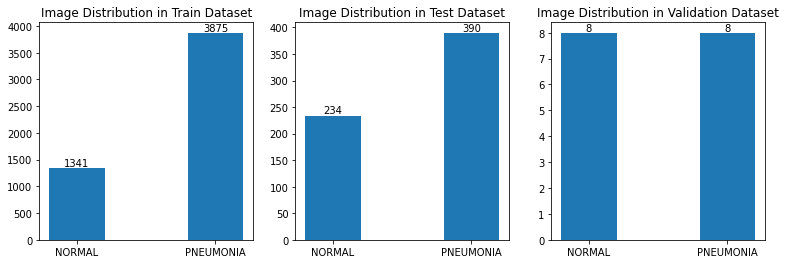

In [3]:
def count_images():
    '''Plots image distribution for each dataset
    
    Returns
    _______
    None
    '''
    fig = plt.figure(figsize=(13, 4))
    
    labels = os.listdir(train_dir)
    count_list = [len(normal_train), len(pneumonia_train)]
    
    # training dataset bar plot
    plt.subplot(1, 3, 1)
    plt.bar(labels, count_list, width=0.4)
    plt.title('Image Distribution in Train Dataset')
    for i in range(len(count_list)):
        plt.text(i, count_list[i], count_list[i], ha='center', va='bottom')
        
    labels = os.listdir(test_dir)
    count_list = [len(normal_test), len(pneumonia_test)]
    
    # testing dataset bar plot
    plt.subplot(1, 3, 2)
    plt.bar(labels, count_list, width=0.4)
    plt.title('Image Distribution in Test Dataset')
    for i in range(len(count_list)):
        plt.text(i, count_list[i], count_list[i], ha='center', va='bottom')
        
    labels = os.listdir(val_dir)
    count_list = [len(normal_val), len(pneumonia_val)]
    
    # validation dataset bar plot
    plt.subplot(1, 3, 3)
    plt.bar(labels, count_list, width=0.4)
    plt.title('Image Distribution in Validation Dataset')
    for i in range(len(count_list)):
        plt.text(i, count_list[i], count_list[i], ha='center', va='bottom')    
    
    plt.show()
    
count_images()

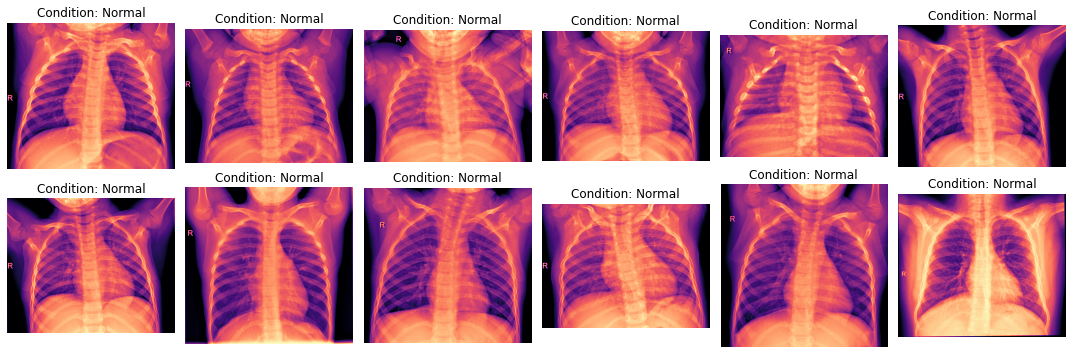

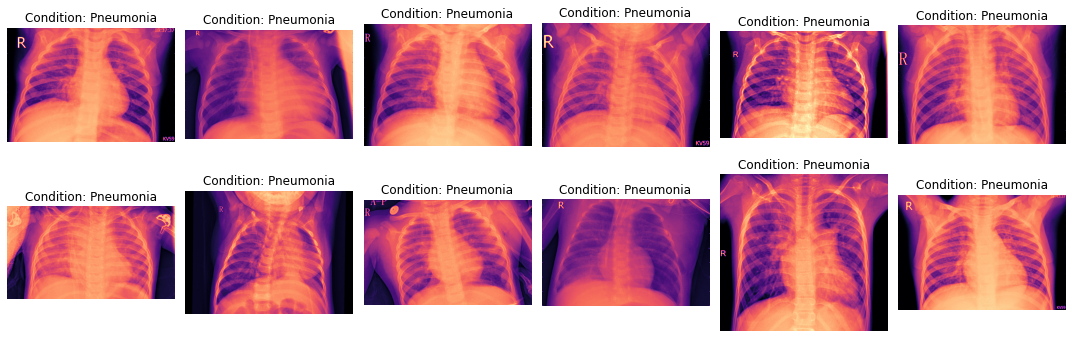

In [4]:
import random
from matplotlib.image import imread
from pathlib import PurePath

def display_images(path):
    '''Plots four random images from given list of paths
    
    Parameters
    __________
    path: list
        List containing paths to images for displaying
    
    Returns
    _______
    None
    '''
    fig, axs = plt.subplots(2, 6, figsize=(15, 5), tight_layout=True)
    axs = axs.ravel()
    
    # list of random images
    img_list = random.sample(path, 12)
    
    for i, img_path in enumerate(img_list):
        img = imread(img_path)
        axs[i].imshow(img, cmap='magma')
        axs[i].axis('off')
        if path == normal_train:
            axs[i].set_title('Condition: Normal', fontsize=12)
        else:
            axs[i].set_title('Condition: Pneumonia', fontsize=12)
    plt.show()
    
display_images(path=normal_train)
display_images(path=pneumonia_train)

Generate <code>TensorFlow</code> datasets from image files (JPEG format).

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

# dataset properties
tf_kwargs = {'labels': 'inferred', # labels are generated from the directory structure
             'color_mode': 'rgb',
             'label_mode': 'categorical',
             'shuffle': True,
             'batch_size': 32,
             'image_size': (256, 256),
            }

train_data = image_dataset_from_directory(directory=train_dir, **tf_kwargs)
test_data = image_dataset_from_directory(directory=test_dir, **tf_kwargs)
val_data = image_dataset_from_directory(directory=val_dir, **tf_kwargs)

# display labels
print('Class labels:', train_data.class_names)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.

Class labels: ['NORMAL', 'PNEUMONIA']


We will define two functions to calculate F1 & F2 scores. F1 score will be one of the metrics used to monitor the learning process. Both scores will be used to evaluate the performance of our classifiers.

In [6]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
import tensorflow.keras.backend as bk

def f1_score(y_true, yhat):
    '''Calculates F1 score for classification task
    
    Parameters
    __________
    y_true: ndarray
        Array with true labels
    yhat: ndarray
        Array with predicted labels
    
    Returns
    _______
    (float) = F1 score
    '''
    true_positives = bk.sum(bk.round(bk.clip(y_true * yhat, 0, 1)))
    possible_positives = bk.sum(bk.round(bk.clip(y_true, 0, 1)))
    predicted_positives = bk.sum(bk.round(bk.clip(yhat, 0, 1)))
    precision = true_positives / (predicted_positives + bk.epsilon())
    recall = true_positives / (possible_positives + bk.epsilon())
    f1_val = 2*(precision * recall)/(precision + recall + bk.epsilon())
    
    return f1_val

def f2_score(y_true, yhat):
    '''Calculates F2 score for classification task
    
    Parameters
    __________
    y_true: ndarray
        Array with true labels
    yhat: ndarray
        Array with predicted labels
    
    Returns
    _______
    (float) = F2 score
    '''
    true_positives = bk.sum(bk.round(bk.clip(y_true * yhat, 0, 1)))
    possible_positives = bk.sum(bk.round(bk.clip(y_true, 0, 1)))
    predicted_positives = bk.sum(bk.round(bk.clip(yhat, 0, 1)))
    precision = true_positives / (predicted_positives + bk.epsilon())
    recall = true_positives / (possible_positives + bk.epsilon())
    f2_val = 5 * (precision * recall)/(4 * precision + recall + bk.epsilon())
    
    return f2_val

Two callbacks will be set:
* <code>EarlyStopping</code> will monitor a metric and stop the training when no improvement is observed,
* <code>ReduceLROnPlateau</code> will reduce the learning rate whenever the learning stagnates - it is believed that sometimes our model will benefit from lowering the learning rate when trapped in the plateau region.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10)

lr_cb = ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-6)

It's time to train our pre-trained models. The new CNNs will have rebuilt tops customized for our images. We will also plot learning curves for each model fitting, confusion matrix, and ROC curve.

### 2. ResNet50V2

In [8]:
from tensorflow.keras.layers import Conv2D, Dense, Normalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Activation, Rescaling
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.applications import ResNet50V2

def create_resnet50_model(conv_base):
    '''Builds CNN from pre-trained ResNet50V2 model
    
    Parameters
    __________
    conv_base: HD5
        pre-trained model
    
    Returns
    _______
    (HD5) = New ResNet50V2 model with rebuilt top
    '''
    # rebuild top
    inputs = Input(shape=(256, 256, 3))
    x = conv_base(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    # output layer
    predictions = Dense(2, activation='sigmoid')(x)

    resnet_model = Model(inputs=[inputs], outputs=predictions, name='ResNet50')

    # compile the model
    resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    
    return resnet_model

resnet50_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet50_base.trainable = False # freeze layers
ResNet50V2_model = create_resnet50_model(conv_base=resnet50_base)

# print number of layers
print('Number of layers:', len(ResNet50V2_model.layers))

Number of layers: 5


In [9]:
# 'class_weight' arg does not work when 'x' is a generator and 'y' is not provided

history_resnet50 = ResNet50V2_model.fit(x=train_data,
                                        epochs=40,
                                        validation_data=val_data,
                                        steps_per_epoch=len(train_data)//32,
                                        callbacks=[early_stopping_cb, lr_cb],
                                        batch_size=32
                                       )

Epoch 1/40
5/5 [==============================] - 13s 2s/step - loss: 27.3401 - accuracy: 0.5500 - f1_score: 0.6168 - val_loss: 51.0048 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - lr: 0.0010
Epoch 2/40
5/5 [==============================] - 8s 2s/step - loss: 12.1186 - accuracy: 0.7125 - f1_score: 0.6906 - val_loss: 11.6442 - val_accuracy: 0.6250 - val_f1_score: 0.3158 - lr: 0.0010
Epoch 3/40
5/5 [==============================] - 8s 2s/step - loss: 6.4063 - accuracy: 0.8313 - f1_score: 0.7117 - val_loss: 21.7362 - val_accuracy: 0.5625 - val_f1_score: 0.5882 - lr: 0.0010
Epoch 4/40
5/5 [==============================] - 8s 2s/step - loss: 4.2991 - accuracy: 0.7500 - f1_score: 0.7105 - val_loss: 8.9528 - val_accuracy: 0.6875 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 5/40
5/5 [==============================] - 8s 2s/step - loss: 2.8652 - accuracy: 0.8125 - f1_score: 0.8389 - val_loss: 10.0966 - val_accuracy: 0.6875 - val_f1_score: 0.6452 - lr: 0.0010
Epoch 6/40
5/5 [=================

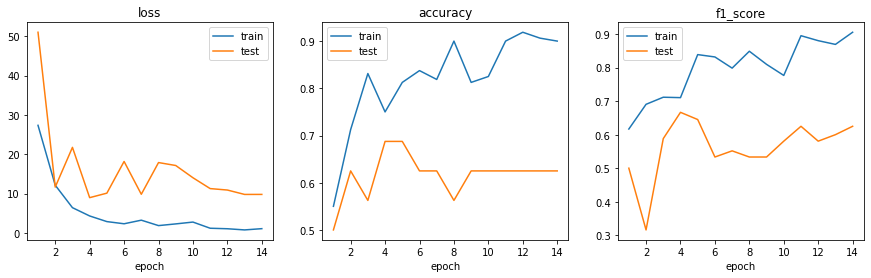

In [10]:
def diagnosis_plots(history):
    '''Plots learning curves from model training history
    
    Parameters
    __________
    history: History
        callback of tracked scores for each epoch
    
    Returns
    _______
    None
    '''
    metric_list =  ['loss', 'accuracy', 'f1_score']
    epochs = len(history.history['loss']) + 1
    
    plt.figure(figsize=(15, 4))
    
    for i, metric in enumerate(metric_list):   
        plt.subplot(1, 3, i+1)
        plt.plot(range(1, epochs), history.history[metric], label='train')
        plt.plot(range(1, epochs), history.history['val_' + metric], label='test')
        plt.title(metric)
        plt.legend(loc='best')
        plt.xlabel('epoch')
    plt.show()

diagnosis_plots(history=history_resnet50)

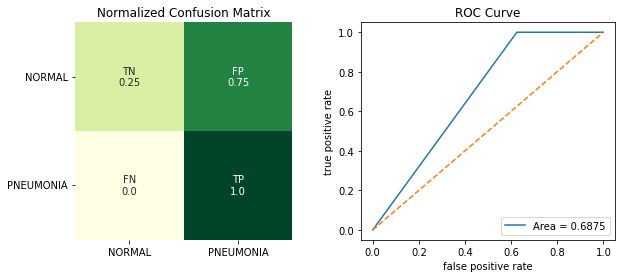

In [11]:
def evaluation_plots(cnn):
    '''Displays normalized confusion matrix and ROC curve
    
    Parameters
    __________
    cnn: HD5
        trained CNN model
    
    Returns
    _______
    None
    '''
    # set empty lists to store images and labels
    val_images = []
    val_labels = []
    
    # iterate through the val dataset and append each batch to a list
    for batch in val_data.as_numpy_iterator():
        val_images.append(batch[0])
        val_labels.append(batch[1])
    
    # stack batches into a single array for both images and labels
    val_images = np.concatenate(val_images, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    
    # get actual class labels
    y_true = np.array(val_labels)
    y_true = tf.argmax(y_true, axis=1).numpy()
    
    # make predictions and convert predicted probabilities into integers/class labels: [0, 1]
    y_proba = cnn.predict(val_images)
    yhat = tf.argmax(y_proba, axis=1).numpy()
    
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    from sklearn.metrics import roc_curve, auc
    
    plt.figure(figsize=(10, 4))
    
    # plot confusion matrix
    plt.subplot(1, 2, 1)
    class_labels = train_data.class_names
    
    # set customized labels
    quarters = ['TN', 'FP', 'FN', 'TP']
    confu_matrix = confusion_matrix(y_true, yhat, normalize='true')
    values = ['{}'.format(value) for value in confu_matrix.flatten()]
    
    labels_ = [f'{i}\n{j}' for i, j in zip(quarters, values)]
    labels = np.asarray(labels_).reshape(2, 2)
    
    # heatmap properties
    hm_kwargs = {'cmap': 'YlGn',
                 'square': True,
                 'annot': labels,
                 'fmt': '',
                 'cbar': False,
                 'xticklabels': class_labels,
                 'yticklabels': class_labels
                }
    
    heatmap(data=confu_matrix, **hm_kwargs)
    plt.title('Normalized Confusion Matrix')
    plt.yticks(rotation=0)
    
    # predictions in float format
    probs = cnn.predict(val_images)[:, 1]
    # optional:
    #probs = cnn.predict_on_batch(val_images)[:, 1]
    
    # plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    plt.plot(fpr, tpr, label='Area = {:.4f}'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve', size=12)
    plt.legend(loc='lower right')
    plt.show()
        
evaluation_plots(cnn=ResNet50V2_model)

### 3. VGG16

In [12]:
# clear session, avoid clutter from old models and layers
from tensorflow.keras import backend

backend.clear_session()

In [13]:
from tensorflow.keras.applications import VGG16

def create_vgg16_model(conv_base):
    '''Builds CNN from pre-trained VGG16 model
    
    Parameters
    __________
    conv_base: HD5
        pre-trained model
    
    Returns
    _______
    (HD5) = New VGG16 model with rebuilt top
    '''
    # rebuild top
    inputs = Input(shape=(256, 256, 3))
    x = conv_base(inputs)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    # output layer
    predictions = Dense(2, activation='sigmoid')(x)

    vgg_model = Model(inputs=[inputs], outputs=predictions, name='VGG16')

    # compile the model
    vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    
    return vgg_model

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg16_base.trainable = False # freeze layers
VGG16_model = create_vgg16_model(conv_base=vgg16_base)

# print number of layers
print('Number of layers:', len(VGG16_model.layers))

Number of layers: 14


In [14]:
history_vgg16 = VGG16_model.fit(x=train_data,
                                epochs=40,
                                validation_data=val_data,
                                steps_per_epoch=len(train_data)//32,
                                callbacks=[early_stopping_cb, lr_cb],
                                batch_size=32
                               )

Epoch 1/40
5/5 [==============================] - 29s 5s/step - loss: 0.3480 - accuracy: 0.8625 - f1_score: 0.8426 - val_loss: 4.9076 - val_accuracy: 0.6875 - val_f1_score: 0.7273 - lr: 0.0010
Epoch 2/40
5/5 [==============================] - 29s 6s/step - loss: 0.1382 - accuracy: 0.9563 - f1_score: 0.9496 - val_loss: 5.8617 - val_accuracy: 0.6250 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 3/40
5/5 [==============================] - 28s 6s/step - loss: 0.1919 - accuracy: 0.9375 - f1_score: 0.9368 - val_loss: 2.6477 - val_accuracy: 0.8125 - val_f1_score: 0.8387 - lr: 0.0010
Epoch 4/40
5/5 [==============================] - 29s 6s/step - loss: 0.0492 - accuracy: 0.9875 - f1_score: 0.9875 - val_loss: 0.7784 - val_accuracy: 0.8750 - val_f1_score: 0.9032 - lr: 0.0010
Epoch 5/40
5/5 [==============================] - 28s 6s/step - loss: 0.0779 - accuracy: 0.9688 - f1_score: 0.9688 - val_loss: 0.4936 - val_accuracy: 0.9375 - val_f1_score: 0.9375 - lr: 0.0010
Epoch 6/40
5/5 [===================

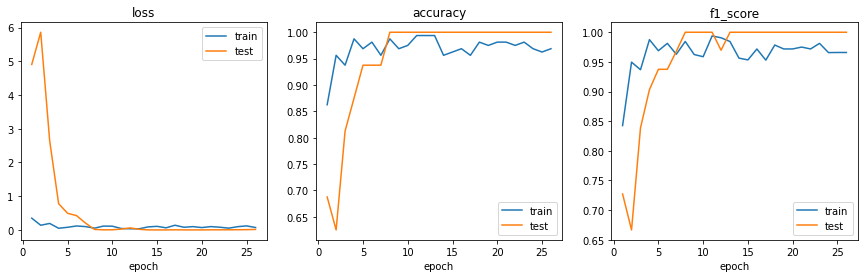

In [15]:
diagnosis_plots(history=history_vgg16)

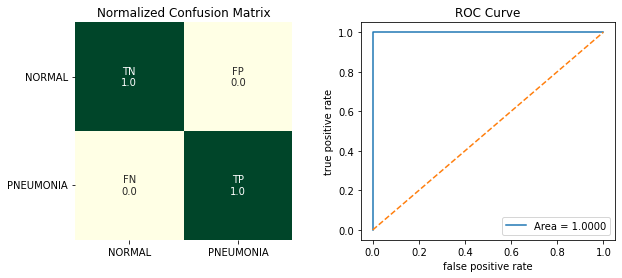

In [16]:
evaluation_plots(cnn=VGG16_model)

### 4. VGG19

In [17]:
# clear previous session
backend.clear_session()

from tensorflow.keras.applications import VGG19

def create_vgg19_model(conv_base):
    '''Builds CNN from pre-trained VGG19 model
    
    Parameters
    __________
    conv_base: HD5
        pre-trained model
    
    Returns
    _______
    (HD5) = New VGG19 model with rebuilt top
    '''
    # rebuild top
    inputs = Input(shape=(256, 256, 3))
    x = conv_base(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    # output layer
    predictions = Dense(2, activation='sigmoid')(x)

    vgg_model = Model(inputs=[inputs], outputs=predictions, name='VGG19')

    # compile the model
    vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    
    return vgg_model

vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg19_base.trainable = False # freeze layers
VGG19_model = create_vgg19_model(conv_base=vgg19_base)

# print number of layers
print('Number of layers:', len(VGG19_model.layers))

Number of layers: 8


In [18]:
history_vgg19 = VGG19_model.fit(x=train_data,
                                epochs=40,
                                validation_data=val_data,
                                steps_per_epoch=len(train_data)//32,
                                callbacks=[early_stopping_cb, lr_cb],
                                batch_size=32,
                               )

Epoch 1/40
5/5 [==============================] - 33s 6s/step - loss: 3.5072 - accuracy: 0.6938 - f1_score: 0.6678 - val_loss: 5.8529 - val_accuracy: 0.5000 - val_f1_score: 0.7442 - lr: 0.0010
Epoch 2/40
5/5 [==============================] - 31s 6s/step - loss: 1.4980 - accuracy: 0.7937 - f1_score: 0.7415 - val_loss: 0.7711 - val_accuracy: 0.8125 - val_f1_score: 0.7857 - lr: 0.0010
Epoch 3/40
5/5 [==============================] - 33s 7s/step - loss: 0.8440 - accuracy: 0.8313 - f1_score: 0.6955 - val_loss: 1.4291 - val_accuracy: 0.6250 - val_f1_score: 0.7805 - lr: 0.0010
Epoch 4/40
5/5 [==============================] - 33s 7s/step - loss: 0.5847 - accuracy: 0.8938 - f1_score: 0.8639 - val_loss: 0.3831 - val_accuracy: 0.9375 - val_f1_score: 0.8649 - lr: 0.0010
Epoch 5/40
5/5 [==============================] - 31s 6s/step - loss: 0.2403 - accuracy: 0.9500 - f1_score: 0.9192 - val_loss: 0.5390 - val_accuracy: 0.8750 - val_f1_score: 0.7200 - lr: 0.0010
Epoch 6/40
5/5 [===================

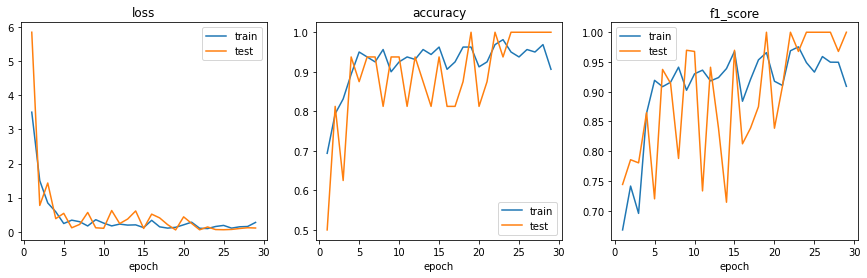

In [19]:
diagnosis_plots(history=history_vgg19)

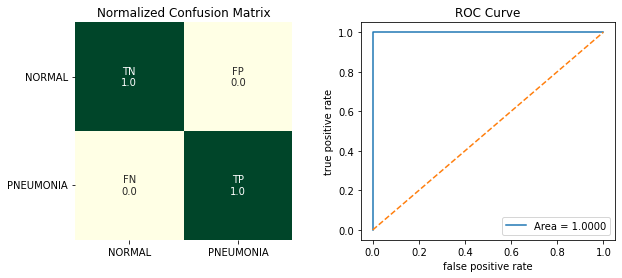

In [20]:
evaluation_plots(cnn=VGG19_model)

### 5. InceptionV3

In [21]:
# clear previous session
backend.clear_session()

from tensorflow.keras.applications.inception_v3 import InceptionV3

def create_inceptionv3_model(conv_base):
    '''Builds CNN from pre-trained InceptionV3 model
    
    Parameters
    __________
    conv_base: HD5
        pre-trained model
    
    Returns
    _______
    (HD5) = New InceptionV3 model with rebuilt top
    '''
    # rebuild top
    inputs = Input(shape=(256, 256, 3))
    x = Normalization()(inputs)
    x = conv_base(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    # output layer
    predictions = Dense(2, activation='sigmoid')(x)

    inceptionv3_model = Model(inputs=[inputs], outputs=predictions, name='InceptionV3')

    # compile the model
    inceptionv3_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    
    return inceptionv3_model

incepv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
incepv3_base.trainable = False # freeze layers
InceptionV3_model = create_inceptionv3_model(conv_base=incepv3_base)

# print number of layers
print('Number of layers:', len(InceptionV3_model.layers))

Number of layers: 7


In [22]:
history_inceptionv3 = InceptionV3_model.fit(x=train_data,
                                            epochs=40,
                                            validation_data=val_data,
                                            steps_per_epoch=len(train_data)//32,
                                            callbacks=[early_stopping_cb, lr_cb],
                                            batch_size=32
                                           )

Epoch 1/40
5/5 [==============================] - 8s 1s/step - loss: 1.2456 - accuracy: 0.9000 - f1_score: 0.8970 - val_loss: 31.7935 - val_accuracy: 0.5625 - val_f1_score: 0.5625 - lr: 0.0010
Epoch 2/40
5/5 [==============================] - 6s 1s/step - loss: 0.4600 - accuracy: 0.9000 - f1_score: 0.9000 - val_loss: 24.4405 - val_accuracy: 0.5625 - val_f1_score: 0.5625 - lr: 0.0010
Epoch 3/40
5/5 [==============================] - 6s 1s/step - loss: 0.3410 - accuracy: 0.9000 - f1_score: 0.9000 - val_loss: 20.9612 - val_accuracy: 0.7500 - val_f1_score: 0.7500 - lr: 0.0010
Epoch 4/40
5/5 [==============================] - 6s 1s/step - loss: 0.3500 - accuracy: 0.8562 - f1_score: 0.8562 - val_loss: 16.0700 - val_accuracy: 0.6875 - val_f1_score: 0.6875 - lr: 0.0010
Epoch 5/40
5/5 [==============================] - 6s 1s/step - loss: 0.5411 - accuracy: 0.8313 - f1_score: 0.8313 - val_loss: 13.6890 - val_accuracy: 0.7500 - val_f1_score: 0.7500 - lr: 0.0010
Epoch 6/40
5/5 [===================

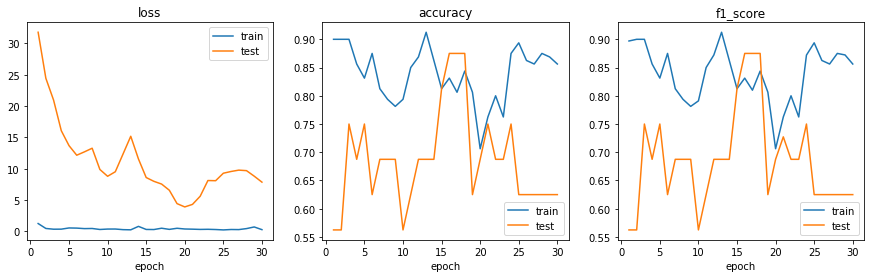

In [23]:
diagnosis_plots(history=history_inceptionv3)

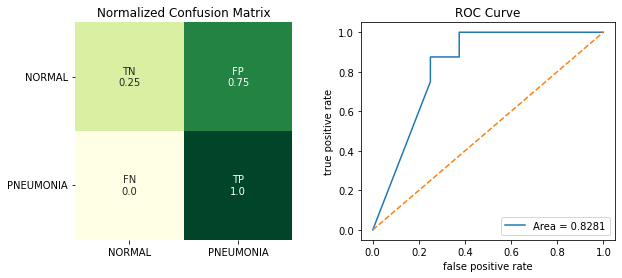

In [24]:
evaluation_plots(cnn=InceptionV3_model)

### 6. EfficientNetB1

In [25]:
# clear previous session
backend.clear_session()

from tensorflow.keras.applications.efficientnet import EfficientNetB1

def create_efficientnetb1_model(conv_base):
    '''Builds CNN from pre-trained EfficientNetB1 model
    
    Parameters
    __________
    conv_base: HD5
        pre-trained model
    
    Returns
    _______
    (HD5) = New EfficientNetB1 model with rebuilt top
    '''
    # rebuild top
    inputs = Input(shape=(256, 256, 3))
    x = conv_base(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    # output layer
    predictions = Dense(2, activation='sigmoid')(x)

    efficientnetb1_model = Model(inputs=[inputs], outputs=predictions, name='EfficientNetB1')

    # compile the model
    efficientnetb1_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    
    return efficientnetb1_model

effnetb1_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
effnetb1_base.trainable = False # freeze layers
EfficientNetB1_model = create_efficientnetb1_model(conv_base=effnetb1_base)

# print number of layers
print('Number of layers:', len(EfficientNetB1_model.layers))

Number of layers: 18


In [26]:
history_efficientnetb1 = EfficientNetB1_model.fit(x=train_data,
                                                  epochs=40,
                                                  validation_data=val_data,
                                                  steps_per_epoch=len(train_data)//32,
                                                  callbacks=[early_stopping_cb, lr_cb],
                                                  batch_size=32
                                                 )

Epoch 1/40
5/5 [==============================] - 16s 2s/step - loss: 0.5692 - accuracy: 0.7625 - f1_score: 0.7590 - val_loss: 0.8773 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - lr: 0.0010
Epoch 2/40
5/5 [==============================] - 8s 2s/step - loss: 0.4908 - accuracy: 0.7312 - f1_score: 0.7068 - val_loss: 0.5511 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - lr: 0.0010
Epoch 3/40
5/5 [==============================] - 8s 2s/step - loss: 0.3785 - accuracy: 0.7437 - f1_score: 0.7588 - val_loss: 0.4209 - val_accuracy: 0.8750 - val_f1_score: 0.9091 - lr: 0.0010
Epoch 4/40
5/5 [==============================] - 7s 2s/step - loss: 0.2656 - accuracy: 0.8875 - f1_score: 0.8674 - val_loss: 0.4689 - val_accuracy: 0.7500 - val_f1_score: 0.7879 - lr: 0.0010
Epoch 5/40
5/5 [==============================] - 7s 2s/step - loss: 0.2173 - accuracy: 0.9125 - f1_score: 0.9154 - val_loss: 0.1866 - val_accuracy: 0.9375 - val_f1_score: 0.9375 - lr: 0.0010
Epoch 6/40
5/5 [=======================

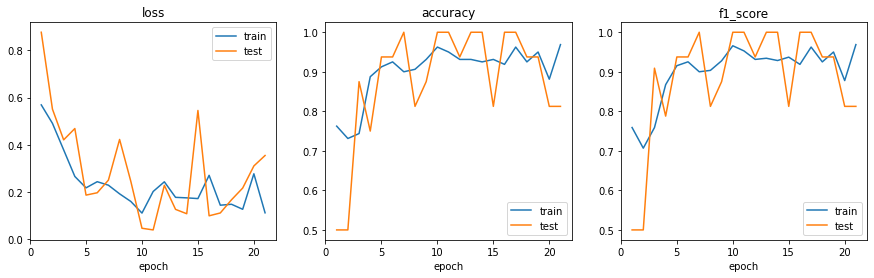

In [27]:
diagnosis_plots(history=history_efficientnetb1)

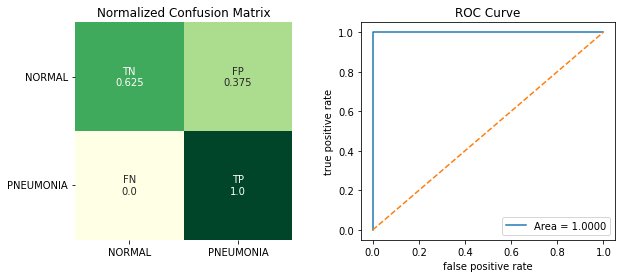

In [28]:
evaluation_plots(cnn=EfficientNetB1_model)

### 7. Evaluation Scores

We trained all CNN models. We will evaluate their performances and usefulness with basic classification scores and present them in tabular form.

In [29]:
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision, AUC

# initialize lists for metric storing
resnet50_scores = []
vgg16_scores = []
vgg19_scores = []
incep_scores = []
effic_scores = []
cnns = []

def evaluation_scores(cnn, score_list):
    '''Calculates basic classification metrics and stores them in given list
    
    Parameters
    __________
    cnn: HD5
        trained CNN model
    score_list: list
        empty list for storing scores
    
    Returns
    _______
    None
    '''
    acc = BinaryAccuracy(name='accuracy')
    rec = Recall(name='recall')
    prec = Precision(name='precision')
    auc = AUC(name='auc')
    
    for batch in test_data.as_numpy_iterator(): 
        X, y = batch
        yhat = cnn.predict(X)
          
        acc.update_state(y, yhat)
        rec.update_state(y, yhat)
        prec.update_state(y, yhat)
        auc.update_state(y, yhat)
        f1_score(y, yhat)
        f2_score(y, yhat)
    
    # append to lists
    score_list.append(acc.result().numpy())
    score_list.append(rec.result().numpy())
    score_list.append(prec.result().numpy())
    score_list.append(auc.result().numpy())
    score_list.append(f1_score(y, yhat).numpy())
    score_list.append(f2_score(y, yhat).numpy())
    cnns.append(cnn.name)
    
evaluation_scores(cnn=ResNet50V2_model, score_list=resnet50_scores)
evaluation_scores(cnn=VGG16_model, score_list=vgg16_scores)
evaluation_scores(cnn=VGG19_model, score_list=vgg19_scores)
evaluation_scores(cnn=InceptionV3_model, score_list=incep_scores)
evaluation_scores(cnn=EfficientNetB1_model, score_list=effic_scores)

In [30]:
from pandas import DataFrame

# display classification metrics
DataFrame.from_records(data=[resnet50_scores, vgg16_scores, vgg19_scores, incep_scores, effic_scores],
                       columns=['accuracy', 'recall', 'precision', 'auc', 'f1_score', 'f2_score'],
                       index=cnns
                      )

,accuracy,recall,precision,auc,f1_score,f2_score
ResNet50,0.832532,0.830128,0.834139,0.875502,0.967742,0.949367
VGG16,0.883814,0.889423,0.879556,0.938604,0.875000,0.875000
VGG19,0.818109,0.823718,0.814580,0.904382,0.848485,0.864197
InceptionV3,0.828526,0.828526,0.828526,0.853080,0.687500,0.687500
EfficientNetB1,0.783654,0.783654,0.783654,0.882095,0.875000,0.875000


Based on all score values the best performing classifier is the VGG16 model.

### 8. Grad-CAM Visualization

Grad-CAM (Gradient-weighted Class Activation Mapping) uses the gradients of any target concept flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept. We will take the best pre-trained model and display examples of superimposed images - heatmaps overlayed on original images after being preprocessed and classified by the model.

In [31]:
# print each layer name & its type in base model
for i, layer in enumerate(vgg16_base.layers):
    print(i + 1, '-->', layer.name, '\t\t-->', layer.__class__.__name__)

1 --> input_1 	--> InputLayer
2 --> block1_conv1 	--> Conv2D
3 --> block1_conv2 	--> Conv2D
4 --> block1_pool 	--> MaxPooling2D
5 --> block2_conv1 	--> Conv2D
6 --> block2_conv2 	--> Conv2D
7 --> block2_pool 	--> MaxPooling2D
8 --> block3_conv1 	--> Conv2D
9 --> block3_conv2 	--> Conv2D
10 --> block3_conv3 	--> Conv2D
11 --> block3_pool 	--> MaxPooling2D
12 --> block4_conv1 	--> Conv2D
13 --> block4_conv2 	--> Conv2D
14 --> block4_conv3 	--> Conv2D
15 --> block4_pool 	--> MaxPooling2D
16 --> block5_conv1 	--> Conv2D
17 --> block5_conv2 	--> Conv2D
18 --> block5_conv3 	--> Conv2D
19 --> block5_pool 	--> MaxPooling2D


In [32]:
# extract name of last convolutional layer
print(list(filter(lambda x: isinstance(x, Conv2D), vgg16_base.layers))[-1].name)

# optional: extract the same name by index (18th layer)
print([layer.name for layer in vgg16_base.layers][17])

# extract base model name
print(vgg16_base.name)

block5_conv3
block5_conv3
vgg16


In [33]:
from tensorflow import keras

def create_gradcam_heatmap(img_path, model, inner_model, layer_name):
    '''Creates Grad-CAM heatmap and predicts condition for given image
    
    Parameters
    __________
    img_path: str
        path to image to predict and construct heatmap
    model: HD5
        trained CNN model
    inner_model: HD5
        base model of passed CNN in 'model' arg
    layer_name: str
        name of last convolutional layer in base model in 'inner_model' arg
    
    Returns
    _______
    (ndarray) = heatmap of image converted into array
    (int) = predicted label: 0 or 1
    '''
    # load the original image and convert into array
    img = keras.preprocessing.image.load_img(img_path, target_size=(256, 256, 3))
    array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(array, axis=0)
    
    # predict the label of the passed image
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    i = np.argmax(preds, axis=1)
    prediction = i[0]

    # generate heatmap
    grad_model = tf.keras.models.Model(
        inputs=[inner_model.inputs],
        outputs=[inner_model.get_layer(layer_name).output, inner_model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array, tf.float32)
        last_conv_layer_output, preds = grad_model(inputs)
        class_channel = preds[:, prediction]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy(), prediction
    
grad_cam, label = create_gradcam_heatmap(img_path='pneumonia_test1.jpg',
                                         model=VGG16_model,
                                         inner_model=VGG16_model.get_layer('vgg16'),
                                         layer_name='block5_conv3'
                                        )

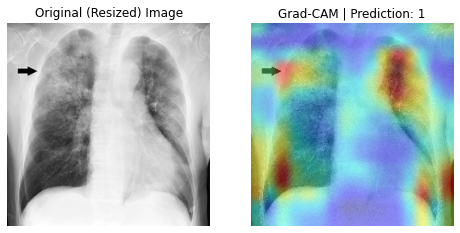

In [34]:
from matplotlib.cm import get_cmap
from PIL import Image

def save_and_display_gradcam(img_path, heatmap, cam_path='grad_cam.jpg', alpha=0.8, cmap='jet'):
    '''Mix together original image, heatmap, and superimposed image and save them
    into a single compose image
    
    Parameters
    __________
    img_path: str
        path to image to original image that has a generated heatmap and prediction
    heatmap: ndarray
        heatmap of image in array format
    cam_path (opt):
        name of superimposed image to save
        default='grad_cam.jpg'
    alpha (opt):
        parameter used as weight for color map when overlapping is applied
        default=0.8
    cmap (opt):
        type of color map used for heatmap
        default='jet'
    
    Returns
    _______
    None
    '''
    # load the original image and convert into array
    img = keras.utils.load_img(img_path, target_size=(256, 256, 3))
    img = keras.utils.img_to_array(img)

    # rescale the heatmap to a range [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # use 'jet' colormap to colorize heatmap
    jet = get_cmap(cmap)

    # use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # superimpose (overlay) the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    
    plt.figure(figsize=(8, 4))
    
    # display original image
    plt.subplot(1, 2, 1)
    img = Image.open(img_path)
    resized = img.resize((256, 256))
    plt.imshow(resized, cmap='gray')
    plt.axis('off')
    plt.title('Original (Resized) Image')
    
    # display Grad-CAM
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM | Prediction: ' + str(label)) # 0 - normal, 1 - pneumonia
    plt.axis('off')
    plt.show()
    
    # save the superimposed image
    if cam_path:
        superimposed_img.save(cam_path)

save_and_display_gradcam(img_path='pneumonia_test1.jpg', heatmap=grad_cam, cam_path=None)

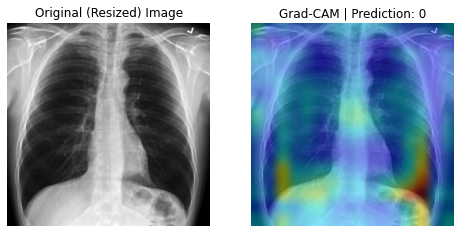

In [35]:
grad_cam, label = create_gradcam_heatmap(img_path='normal_test1.jpg',
                                         model=VGG16_model,
                                         inner_model=VGG16_model.get_layer('vgg16'),
                                         layer_name='block5_conv3'
                                        )

save_and_display_gradcam(img_path='normal_test1.jpg', heatmap=grad_cam, cam_path=None)

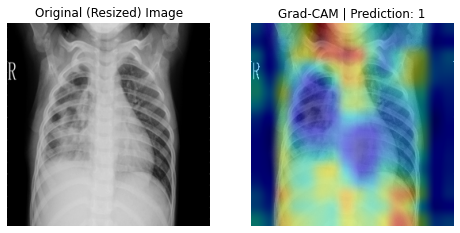

In [36]:
grad_cam, label = create_gradcam_heatmap(img_path='pneumonia_test2.jpeg',
                                         model=VGG16_model,
                                         inner_model=VGG16_model.get_layer('vgg16'),
                                         layer_name='block5_conv3'
                                        )

save_and_display_gradcam(img_path='pneumonia_test2.jpeg', heatmap=grad_cam, cam_path=None)

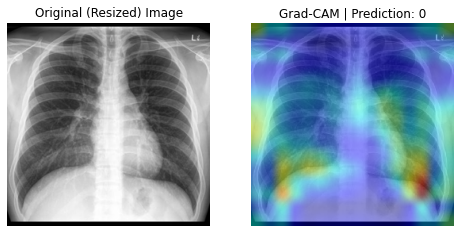

In [37]:
grad_cam, label = create_gradcam_heatmap(img_path='normal_test2.jpg',
                                         model=VGG16_model,
                                         inner_model=VGG16_model.get_layer('vgg16'),
                                         layer_name='block5_conv3'
                                        )

save_and_display_gradcam(img_path='normal_test2.jpg', heatmap=grad_cam, cam_path=None)

The Grad-CAM heatmaps emphasize mostly the lower parts of the chest cavity, especially the left hemidiaphragm. In case of patients with pneumonia, the heatmap focuses on the higher regions searching for lung inflammations.

Finally, we will create a simple animation displaying Grad-CAM heatmap improvement. This will be a GIF of Grad-CAM heatmaps over all model layers.

In [38]:
conv_layers = []

# extract convolution layer names from inner model
for layer in vgg16_base.layers:
    if layer.__class__ == Conv2D:
        conv_layers.append(layer.name)

In [39]:
def generate_and_save_gradcams(img_path):
    '''Loops through list of convolution layers, generates a heatmap for each layer, and saves it
    
    Parameters
    __________
    img_path: str
        path to image to original image that has a generated heatmap and prediction
    
    Returns
    _______
    None
    '''
    for layer in conv_layers:
        grad_cam, label = create_gradcam_heatmap(img_path,
                                                 model=VGG16_model,
                                                 inner_model=VGG16_model.get_layer('vgg16'),
                                                 layer_name=layer
                                                )
        
        # load the original image and convert into array
        img = keras.utils.load_img(img_path, target_size=(256, 256, 3))
        img = keras.utils.img_to_array(img)
    
        # rescale the heatmap to a range [0, 255]
        heatmap = np.uint8(255 * grad_cam)
    
        # use 'jet' colormap to colorize heatmap
        jet = get_cmap('jet')
    
        # use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
    
        # create an image with RGB colorized heatmap
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
        # superimpose (overlay) the heatmap on original image
        superimposed_img = jet_heatmap * 0.8 + img
        superimposed_img = keras.utils.array_to_img(superimposed_img)
        
        plt.figure(figsize=(4, 4))
        
        # save Grad-CAM
        plt.imshow(superimposed_img)
        plt.title(f'{layer}')
        plt.axis('off')
        plt.savefig(f'gradcams/{layer}.jpg')
        plt.close()
        
generate_and_save_gradcams(img_path='pneumonia_test1.jpg')        

In [40]:
def create_gif():
    '''Generates GIF file from images in given directory
    
    Parameters
    __________
    None
    
    Returns
    _______
    None
    '''
    frames = [Image.open(image) for image in glob('gradcams/*conv*.jpg')]
    
    frames[0].save('gradcam_vgg16.gif', format='GIF', append_images=frames[1:],
                   save_all=True, duration=500, loop=0, fps=24)
    
create_gif()

<img src='gradcam_vgg16.gif' width='250' align='center'>

### 9. Conclusion

In this notebook we performed a binary classification problem on a dataset of X-rays to detect pneumonia. We used transfer learning to complete this task - reused different pre-trained models for our new task. The evaluation showed the VGG16 model to be the best CNN in terms of performance. The classifier made accurate predictions on provided chest images. 